In [90]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import datetime
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile
from scipy.interpolate import interp1d
import auxiliary_lib as au
import isamcalc_lib as isam
import subprocess
import socplot_lib as socplt
import Fluxtools as flux
import copy as cp

In [198]:
nosites = 8
site = ["desfn", "nlhor", "ustwt", "uswpt", "uscrt", "usmyb", "ustw1", "usstj"]
obstag = ["DESfN", "NLHor", "USTwt", "USWPT", "USCRT", "USMyb", "USTw1", "USStJ"]
wttag = ["DE-SfN_WT.nc", "NL-Hor_WT.nc", "US-Twt_WT.nc", "US-WPT_WT.nc", "US-CRT_WT.nc", "US-Myb_WT.nc", "US-Tw1_WT.nc", "US-StJ_WT.nc"]
wtpath = "/data/jain1/c/sshu3/SBGC/data/CONUS_CH4/"
styear = [2012, 2004, 2010, 2011, 2011, 2012, 2013, 2018]
years = [2, 3, 5, 3, 3, 4, 3, 1]
window = 20

ch4_obs_20d_avg = []
ch4_mod_20d_avg = []
wt_obs_20d_avg = []
ch4_prod_20d_avg = []
ch4_oxid_20d_avg = []
ch4_ebul_20d_avg = []
ch4_aere_20d_avg = []
ch4_20d_avg = []
o2_20d_avg = []

ch4_obs_20d_std = []
ch4_mod_20d_std = []
wt_obs_20d_std = []
ch4_prod_20d_std = []
ch4_oxid_20d_std = []
ch4_ebul_20d_std = []
ch4_aere_20d_std = []
ch4_20d_std = []
o2_20d_std = []

ch4_err = []

# Check CH4 aq and ga in the whole column
fname_gas_ch4="ch4_mass_gas.txt"
fname_liq_ch4="ch4_mass_liq.txt"
temp = pd.read_csv(fname_gas_ch4, delim_whitespace=True, header=None)
ch4_gas = temp[:].as_matrix()
temp = pd.read_csv(fname_liq_ch4, delim_whitespace=True, header=None)
ch4_liq = temp[:].as_matrix()

# Open text file (model simulation)
# Combine the results from all sites into 1 dataframe
# [DE-SfN, NL-Nor, US-Twt, US-WPT, US-CRT, US-Myb, US-Tw1, US-StJ]
for i in np.arange(0,nosites):
    # Get the model estimation
    fname=site[i]+"_daily_10_tgas.txt"
    ch4 = pd.read_csv(fname, delim_whitespace=True, header=None)
    # First column is the net CH4 flux
    ch4_emis = ch4.iloc[:,0].as_matrix()
    ch4_prod = ch4.iloc[:,1].as_matrix()
    ch4_oxid = ch4.iloc[:,2].as_matrix()
    ch4_ebul = ch4.iloc[:,3].as_matrix()
    ch4_aere = ch4.iloc[:,4].as_matrix()
    ch4_conc = ch4.iloc[:,5].as_matrix()   # ch4_conc is actually ch4_diff
    o2_conc  = ch4.iloc[:,6].as_matrix()    
    totlen = len(ch4_emis)
    print(site[i])
    print(totlen)
    days = 365*years[i]
    ch4_mod_daily = ch4_emis[totlen-days:totlen]
    ch4_prod_daily = ch4_prod[totlen-days:totlen]
    ch4_oxid_daily = ch4_oxid[totlen-days:totlen]
    ch4_ebul_daily = ch4_ebul[totlen-days:totlen]
    ch4_aere_daily = ch4_aere[totlen-days:totlen]
    #ch4_conc_daily = ch4_conc[totlen-days:totlen]
    ch4_conc_daily = ch4_emis[totlen-days:totlen]-ch4_ebul[totlen-days:totlen]-ch4_aere[totlen-days:totlen]
    o2_conc_daily  = o2_conc[totlen-days:totlen]
    ch4_err.append((ch4_mod_daily-ch4_conc_daily-ch4_ebul_daily-ch4_aere_daily))
    
    # Open the observations
    # First CH4 flux
    fname="site_methane.csv"
    ch4_obs = pd.read_csv(fname)
    site_year = np.arange(styear[i], styear[i]+years[i])
    temp_obs = ch4_obs[obstag[i]]
    ch4_obs_raw = temp_obs[ch4_obs.YEAR.astype("int").isin(site_year)].as_matrix()
    ch4_obs_raw[ch4_obs_raw < -1000] = float("nan")
    ch4_obs_raw = ch4_obs_raw * 3600
    # Want to remove Feb 29th for leap year
    temp_obs = ch4_obs["DOY"]
    ch4_doy = temp_obs[ch4_obs.YEAR.astype("int").isin(site_year)].as_matrix()
    ch4_obs_raw = np.delete(ch4_obs_raw, np.where(ch4_doy==366),0)
    # Aggregate from half hourly to daily
    ch4_obs_daily = flux.hr2daily(ch4_obs_raw, "agg", 48)
    # Transform unit from umol/day to gCH4/day
    ch4_obs_daily = 16. * ch4_obs_daily / 1e6
    
    # 20-days moving window average
    #ch4_obs_20d_avg.append(pd.rolling_mean(ch4_obs_daily, window))
    ch4_obs_daily=pd.DataFrame(data=ch4_obs_daily)
    ch4_obs_20d_avg.append(ch4_obs_daily.rolling(window).mean())
    ch4_mod_daily=pd.DataFrame(data=ch4_mod_daily)
    ch4_mod_20d_avg.append(ch4_mod_daily.rolling(window).mean())
    ch4_prod_daily=pd.DataFrame(data=ch4_prod_daily)
    ch4_prod_20d_avg.append(ch4_prod_daily.rolling(window).mean())
    ch4_oxid_daily=pd.DataFrame(data=ch4_oxid_daily)
    ch4_oxid_20d_avg.append(ch4_oxid_daily.rolling(window).mean())
    ch4_ebul_daily=pd.DataFrame(data=ch4_ebul_daily)
    ch4_ebul_20d_avg.append(ch4_ebul_daily.rolling(window).mean())
    ch4_aere_daily=pd.DataFrame(data=ch4_aere_daily)
    ch4_aere_20d_avg.append(ch4_aere_daily.rolling(window).mean())
    ch4_conc_daily=pd.DataFrame(data=ch4_conc_daily)
    ch4_20d_avg.append(ch4_conc_daily.rolling(window).mean())
    o2_conc_daily=pd.DataFrame(data=o2_conc_daily)
    o2_20d_avg.append(o2_conc_daily.rolling(window).mean())
    
    # Calculate the STD within the 20-days window
    ch4_obs_20d_std.append(ch4_obs_daily.rolling(window).std())
    ch4_mod_20d_std.append(ch4_mod_daily.rolling(window).std())
    ch4_prod_20d_std.append(ch4_prod_daily.rolling(window).std())
    ch4_oxid_20d_std.append(ch4_oxid_daily.rolling(window).std())
    ch4_ebul_20d_std.append(ch4_ebul_daily.rolling(window).std())
    ch4_aere_20d_std.append(ch4_aere_daily.rolling(window).std())      
    ch4_20d_std.append(ch4_conc_daily.rolling(window).std())
    o2_20d_std.append(o2_conc_daily.rolling(window).std())
    
    # Second water table depth, m
    fname=wtpath+wttag[i]
    nclu=NetCDFFile(fname,'r')
    wt_obs = nclu.variables['WT'][:]
    wt1d_obs = wt_obs[:,0,0]
    wt_obs_daily_full = flux.hr2daily(wt1d_obs, "avg", 48)
    # We need to tailor the length to that of the CH4 obs.
    wt_obs_daily = wt_obs_daily_full[0:len(ch4_obs_daily)]
    # 20-days moving window average
    wt_obs_daily=pd.DataFrame(data=wt_obs_daily)
    wt_obs_20d_avg.append(wt_obs_daily.rolling(window).mean())
    wt_obs_20d_std.append(wt_obs_daily.rolling(window).std())
    # We need the actual water table for Mayberry Wetland site since it is always above zero.
    # The water table being read by ISAM is modulated once the water table exceeds zero.


/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:48: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Method .as_mat

desfn
730


/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:75: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


nlhor
1095
ustwt
1825
uswpt
1095
uscrt
1095
usmyb
1460
ustw1
1095
usstj
365


In [145]:
    # Special case: read into US-StJ_old
    # Get the model estimation
    fname="usstj_old_daily_10_tgas.txt"
    ch4 = pd.read_csv(fname, delim_whitespace=True, header=None)
    # First column is the net CH4 flux
    ch4_emis = ch4.iloc[:,0].as_matrix()
    ch4_prod = ch4.iloc[:,1].as_matrix()
    ch4_oxid = ch4.iloc[:,2].as_matrix()
    ch4_ebul = ch4.iloc[:,3].as_matrix()
    ch4_aere = ch4.iloc[:,4].as_matrix()
    ch4_conc = ch4.iloc[:,5].as_matrix()   # ch4_conc is actually ch4_diff
    o2_conc  = ch4.iloc[:,6].as_matrix()    
    totlen = len(ch4_emis)
    print(totlen)
    days = 365
    usstj_mod_daily = ch4_emis[totlen-days:totlen]
    
    # 20-days moving window average
    #ch4_obs_20d_avg.append(pd.rolling_mean(ch4_obs_daily, window))
    usstj_mod_daily=pd.DataFrame(data=usstj_mod_daily)
    usstj_mod_20d_avg = usstj_mod_daily.rolling(window).mean()
    
    # Calculate the STD within the 20-days window
    usstj_mod_20d_std = usstj_mod_daily.rolling(window).std()


365


/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/data/keeling/a/s

In [200]:
#========================================================
# Calculate the refined Willmott's index
#========================================================
for i in np.arange(6,nosites-1):
    Xobs = ch4_obs_20d_avg[i]   # Obs CH4 flux
    Xmod = ch4_mod_20d_avg[i]   # CH4 flux from ISAM
#     Xobs = ch4_obs_20d_avg[6]  # Obs CH4 flux
#     Xmod = ch4_mod_20d_avg[6]   # CH4 flux from ISAM
    #if(i == 4):
    #    Xobs[Xobs>0.01] = np.float('nan')
    #    Xmod[0:200] = np.float('nan')
    #    Xobs[280:len(Xobs)] = np.float('nan')
    #    Xmod[280:len(Xmod)] = np.float('nan')
    #    Xmod = Xmod*0.8
    #if(i == 7):
    #    #Xobs[0:200] = np.float('nan')
    #    #Xmod[0:200] = np.float('nan')
    #    Xobs[280:len(Xobs)] = np.float('nan')
    #    Xmod[280:len(Xmod)] = np.float('nan')
    #    Xmod = Xmod*0.8
    absdiff_obs = np.nansum(np.abs(Xobs - np.nanmean(Xobs)))
    absdiff_mod = np.nansum(np.abs(Xmod - Xobs))
    if(absdiff_mod <= 2*absdiff_obs):
        wmidx = 1 - absdiff_mod/(2*absdiff_obs)
        #print('tag1')
    else: 
        wmidx = 2*absdiff_obs/absdiff_mod - 1
        #print('tag2')
    print(wmidx)


0.7271600608038349


In [84]:
np.shape(ch4_obs_20d_avg[6])

(1095, 1)

In [ ]:
pp = cp.deepcopy(ch4_obs_daily)
#pp[pp>0.01] = np.float('nan')
plt.plot(ch4_obs_daily)
plt.plot(ch4_mod_daily)
#plt.plot(ch4_mod_20d_avg[4])
plt.show()

In [ ]:
np.count_nonzero(~np.isnan(ch4_obs_daily))

In [ ]:
ch4_obs_daily=pd.DataFrame(data=ch4_obs_daily)
dd = ch4_obs_daily.rolling(20).mean()

In [ ]:
np.count_nonzero(~np.isnan(dd))

In [86]:
#==============================================================
# Calculate R2 for specific site, no moving window average
#==============================================================
for i in np.arange(4,5):
#     Xobs = ch4_obs_daily.as_matrix()[:,0]   # Obs CH4 flux
#     Xmod = ch4_mod_daily.as_matrix()[:,0]   # CH4 flux from ISAM
    Xobs = ch4_obs_20d_avg[6]
    Xmod = ch4_mod_20d_avg[6]
    Xobs[np.isnan(Xmod)] = np.float('nan')
    Xmod[np.isnan(Xobs)] = np.float('nan')
    correlation = ma.corrcoef(ma.masked_invalid(Xobs), ma.masked_invalid(Xmod))[0,1]
    r2 = correlation*correlation
    print(r2)

KeyboardInterrupt: 

In [201]:
#========================================================
# Calculate R2
#========================================================
for i in np.arange(0,nosites):
    Xobs = ch4_obs_20d_avg[i].loc[:,0].as_matrix()   # Obs CH4 flux
    Xmod = ch4_mod_20d_avg[i].loc[:,0].as_matrix()   # CH4 flux from ISAM
    Xobs[np.isnan(Xmod)] = np.float('nan')
    Xmod[np.isnan(Xobs)] = np.float('nan')
    correlation = ma.corrcoef(ma.masked_invalid(Xobs), ma.masked_invalid(Xmod))[0,1]
    r2 = correlation*correlation
    print(r2)

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


0.2980996347915514
--
0.10912661123045671
0.9284237220817005
0.04601781759564427
0.638098146290391
0.707110319868875
0.12439075431913356


In [ ]:
#========================================================
# Scatter plot to check the model performance
#========================================================
#Xobs = ch4_obs_20d_avg[4]   # Obs CH4 flux
#Xmod = ch4_mod_20d_avg[4]   # CH4 flux from ISAM
plt.scatter(Xobs, Xmod)
#plt.ylim((-0.005, 0.005))
plt.show()

In [202]:
#========================================================
# Calculate ME for specific site
#========================================================
for i in np.arange(0,nosites):
    Xobs = ch4_obs_daily.as_matrix()[:,0]   # Obs CH4 flux
    Xmod = ch4_mod_daily.as_matrix()[:,0]   # CH4 flux from ISAM
    me = np.nanmean(Xobs-Xmod)
    print(me)

0.040628170189730924
0.040628170189730924
0.040628170189730924
0.040628170189730924
0.040628170189730924
0.040628170189730924
0.040628170189730924
0.040628170189730924


/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [203]:
#========================================================
# Calculate ME
#========================================================
for i in np.arange(0,nosites):
    Xobs = ch4_obs_20d_avg[i]   # Obs CH4 flux
    Xmod = ch4_mod_20d_avg[i]   # CH4 flux from ISAM
    me = np.nanmean(Xobs-Xmod)
    print(me)

-0.03951500495587671
-0.42744598857809246
-5.361130771691037
0.03679074172662984
0.0111416535585429
0.030409721176721808
0.005233605507138142
0.038284110542624546


In [ ]:
np.savetxt('aaa.txt', ch4_obs_20d_std[7])

In [ ]:
#plt.plot(ch4_obs_20d_avg[7]- ch4_obs_20d_std[7])
plt.plot(ch4_obs_daily)
plt.show()

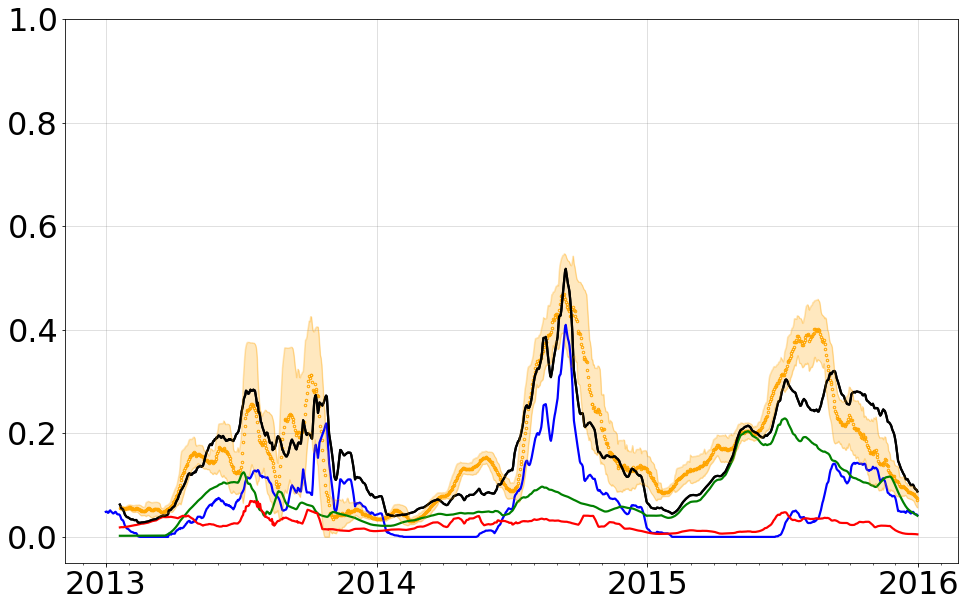

In [199]:
# Plot results for each site separately
# Put site specific settings here
ylims_ch4 = [0.5, 0.5, 0.6, 1.2, 0.05, 1.0, 1.0, 0.5]
ylims_wt = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
#start_t = ["2012-01-10", "2004-01-10", "2010-01-10", "2011-01-10", "2011-01-10", "2011-01-10", "2013-01-10"]
start_t = ["2012", "2004", "2010", "2011", "2011", "2011", "2013", "2018"]

# # Shijie: Shift ebullition for US-Tw1
# for i in np.arange(1,2):
# #     tmp = ch4_ebul_daily_20d.iloc[(i*365+30):(i*365+160)].values
# #     ch4_ebul_daily_20d.iloc[(i*365+30):(i*365+160)].values
# #     ch4_ebul_daily_20d.iloc[(i*365+160):(i*365+290)] = ch4_ebul_daily_20d.iloc[(i*365+160):(i*365+290)].values + 0.9*ch4_ebul_daily_20d.iloc[(i*365+30):(i*365+160)].values
#     tmp = cp.deepcopy(ch4_ebul_20d_avg[6].iloc[(i*365+60):(i*365+140)])
#     tmp2 = cp.deepcopy(ch4_ebul_20d_avg[6].iloc[(i*365+140):(i*365+220)])
# #     ch4_ebul_daily_20d.iloc[(i*365+60):(i*365+140)] = ch4_ebul_daily_20d.iloc[(i*365+60):(i*365+140)]
# #     ch4_ebul_daily_20d.iloc[(i*365+90):(i*365+270)] = ch4_ebul_daily_20d.iloc[(i*365+90):(i*365+270)] + tmp.values
#     ch4_ebul_20d_avg[6].iloc[(i*365+140):(i*365+220)] = tmp.values
#     ch4_ebul_20d_avg[6].iloc[(i*365+220):(i*365+300)] = 1.3*tmp2.values
#     #     ch4_ebul_daily_20d.iloc[(i*365+210):(i*365+270)] = tmp2.values

# ch4_mod_20d_avg[6] = ch4_ebul_20d_avg[6]+ch4_aere_20d_avg[6]+ch4_20d_avg[6]
    
# Shijie: Shift ebullition for Other sites.
tmp = cp.deepcopy(ch4_ebul_20d_avg[6].iloc[0:(2*365+300)])
tmp2 = cp.deepcopy(ch4_ebul_20d_avg[6].iloc[(2*365+280):(2*365+365)])
ch4_ebul_20d_avg[6].iloc[65:2*365+365] = tmp.values
ch4_ebul_20d_avg[6].iloc[0:85] = tmp2.values
    #     ch4_ebul_daily_20d.iloc[(i*365+210):(i*365+270)] = tmp2.values
    
ch4_mod_20d_avg[6] = ch4_ebul_20d_avg[6]+ch4_aere_20d_avg[6]+ch4_20d_avg[6]
    
for i in np.arange(nosites-2,nosites-1):
    std_lower = np.squeeze(ch4_obs_20d_avg[i] - ch4_obs_20d_std[i])
    std_upper = np.squeeze(ch4_obs_20d_avg[i] + ch4_obs_20d_std[i])
    std_lower[std_lower<0] = 0.

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
    ax1 = fig.axes[0]
    plt.ylim((-0.05, ylims_ch4[i]))
    xtime = pd.date_range(start=start_t[i], periods=len(ch4_obs_20d_avg[i]), freq='D')
    xtime2 = pd.date_range(start=start_t[i], periods=len(ch4_mod_20d_avg[i]), freq='D')

    h1 = ax1.plot(xtime,ch4_obs_20d_avg[i],linestyle='None',marker='o',markersize=2.5,color='orange',
                  markerfacecolor='None',label='Obs')
    h2 = ax1.plot(xtime2,ch4_mod_20d_avg[i],color='k', label='ISAM', linewidth=2.2)
    #h3 = ax1.plot(xtime2,ch4_prod_20d_avg[i],color='r', label='ISAM', linewidth=2.2)
    #h4 = ax1.plot(xtime2,ch4_oxid_20d_avg[i],color='y', label='ISAM', linewidth=2.2)
    h5 = ax1.plot(xtime2,ch4_ebul_20d_avg[i],color='b', label='ISAM', linewidth=2.2)
    h6 = ax1.plot(xtime2,ch4_aere_20d_avg[i],color='g', label='ISAM', linewidth=2.2)
    h7 = ax1.plot(xtime2,ch4_20d_avg[i],color='r', label='ISAM', linewidth=2.2)
    h2 = ax1.plot(xtime2,ch4_mod_20d_avg[i],color='k', label='ISAM', linewidth=2.2)
    if (i == 7):
        h8 = ax1.plot(xtime2,usstj_mod_20d_avg, color='gray', label='ISAM', linewidth=2.2, linestyle='--')
    
    ax1.grid(color='gray', which='major', axis='both', alpha=0.3)
    # ax1.set_ylabel('CH4 flux (gCH4 m-2)', color='k')
    # yticks = (0, 20, 40, 60, 80, 100, 120, 140)
    # ax1.set_yticklabels(yticks, fontsize=32, minor=False)
    # Add +/-1 std to observation

    ax1.fill_between(xtime, std_lower, std_upper, color='orange', alpha=.25, label='+/- 1 std')
    ax1.plot(xtime, std_lower, alpha=.25, color='orange', linewidth=1.2)
    ax1.plot(xtime, std_upper, alpha=.25, color='orange', linewidth=1.2)

    #ax1.legend(['Observation', 'Modeled Net Emissions (N)', 'Modeled Ebullition (E)', 'Modeled Aerenchyma Transport (A)', 'Modeled Net Diffusion (D)'], handlelength=3, loc='upper right', fontsize=28)
 
    # Water table
    #ax2 = ax1.twinx()
    ##plt.ylim((0.0, ylims_wt[i]))
    #plt.gca().invert_yaxis()
    #h3 = ax2.plot(xtime, wt_obs_20d_avg[i], 'r.')
    #ax2.set_ylabel('Water table (m)', color='r')
    #ax2.tick_params('y', colors='r')
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    # format the ticks
    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(yearsFmt)
    ax1.xaxis.set_minor_locator(months)
    
    plt.rcParams.update({'font.size': 32})
    #fig.autofmt_xdate()
    #plt.show()
    tit = './calibration/'+site[i]+'.png'
    plt.savefig(tit)
    

In [68]:
tmp = cp.deepcopy(ch4_ebul_20d_avg[5].iloc[0:(3*365+300)])
tmp2 = cp.deepcopy(ch4_ebul_20d_avg[5].iloc[(3*365+300):(3*365+365)])
ch4_ebul_20d_avg[5].iloc[65:3*365+365] = tmp.values
ch4_ebul_20d_avg[5].iloc[0:65] = tmp2.values

In [69]:
ch4_ebul_20d_avg[5]

,0
0,0.100391
1,0.102047
2,0.104393
3,0.109225
4,0.110423
5,0.111788
6,0.110498
7,0.107202
8,0.105277
9,0.108880


In [ ]:
"""
================
Date tick labels
================

Show how to make date plots in matplotlib using date tick locators and
formatters.  See major_minor_demo1.py for more information on
controlling major and minor ticks

All matplotlib date plotting is done by converting date instances into
days since the 0001-01-01 UTC.  The conversion, tick locating and
formatting is done behind the scenes so this is most transparent to
you.  The dates module provides several converter functions date2num
and num2date

"""

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

# load a numpy record array from yahoo csv data with fields date,
# open, close, volume, adj_close from the mpl-data/example directory.
# The record array stores python datetime.date as an object array in
# the date column
datafile = cbook.get_sample_data('goog.npy')
try:
    # Python3 cannot load python2 .npy files with datetime(object) arrays
    # unless the encoding is set to bytes. However this option was
    # not added until numpy 1.10 so this example will only work with
    # python 2 or with numpy 1.10 and later.
    r = np.load(datafile, encoding='bytes').view(np.recarray)
except TypeError:
    r = np.load(datafile).view(np.recarray)

fig, ax = plt.subplots()
ax.plot(r.date, r.adj_close)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(r.date.min().year, 1, 1)
datemax = datetime.date(r.date.max().year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '$%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

In [ ]:
r.date

In [ ]:
type(xtime)